# Laboratorium 2 - wieloręcy bandyci

## Przygotowanie

 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab2`
 * zainstaluj potrzebne biblioteki:
 `pip3 install matplotlib`
 * upewnij się, że plik `bandit_framework.py` najduje się w tym samym katalogu

## Część 1. - framework i naiwni bandyci

In [1]:
# importujemy wszystkie potrzebne pakiety

from copy import copy
from math import log, sqrt
from itertools import product
from random import betavariate, sample, shuffle, uniform
from bandit_framework import *  # pakiet ze srodowiskiem testowym

In [2]:
# inicjalizujemy parametry testu

runs = 50
epochs = 1000
recommendation_size = 10

In [3]:
# inicjalizujemy ramiona bandytow - payout kazdego ramienia bedzie reprezentowany przez rozklad normalny
# te ramiona dobrze reprezentują CTR, czyli funkcje celu o rozkladzie Bernoulliego
# mamy prawdopodobienstwo aktywacji (klikniecia) p i staly payout po kliknieciu
# Mozemy takze przygotowac inne typy ramion, np. z payoutem losowanym z rozkladu normalnego lub wykladniczego

good_arms = [Arm(f'good_{i}', uniform(0.5, 0.7), lambda: 1) for i in range(10)]
bad_arms = [Arm(f'bad_{i}', uniform(0.1, 0.4), lambda: 1) for i in range(90)]
arms = {arm.arm_id: arm for arm in good_arms + bad_arms}
arm_ids = list(arms.keys())

In [4]:
expected_highest_payout_per_epoch = sum(
    sorted([arm.activation_probability for arm in arms.values()], reverse=True)[:10]
)
print(f'Expected highest average payout per epoch: {expected_highest_payout_per_epoch}')

Expected highest average payout per epoch: 6.111917273998752


In [5]:
# pierwszy bandyta - wybiera losowe ramiona

class Random(Bandit):
    def __init__(self, bandit_id, arm_ids):
        super().__init__(bandit_id, arm_ids)

    def recommend(self, size):
        return sample(self.arm_ids, size)

    def feedback(self, arm_id, payout):
        pass

In [6]:
# ten bandyta oszukuje - zna mozliwosci kazdego z ramion i wybiera najelpsze - przyda nam sie do porownania

class Perfect(Bandit):
    def __init__(self, bandit_id, arm_ids, arms):
        super().__init__(bandit_id, arm_ids)
        self.arms = arms
        self.expected_payouts = {}
        for arm in arms.values():
            self.expected_payouts[arm.arm_id] = self.__find_expected_value(
                arm.payout_function) * arm.activation_probability
        self.arm_ids_sorted_by_expected_payout = [x[0] for x in
                                                  sorted(self.expected_payouts.items(), key=lambda x: x[1],
                                                         reverse=True)]

    def recommend(self, size):
        return self.arm_ids_sorted_by_expected_payout[:size]

    def feedback(self, arm_id, payout):
        pass

    def __find_expected_value(self, payout_function, n=100000):
        # brzydka, ale skuteczna sztuczka, zeby metoda brute-force znalexc wartosc oczekiwana
        return sum([payout_function() for i in range(n)]) / n

In [7]:
# tworzymy liste bandytow do przetestowania

bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

In [8]:
# uruchamiamy test

runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect



Aggregated results:

perfect: 6113.140000000005
random: 2876.620000000004


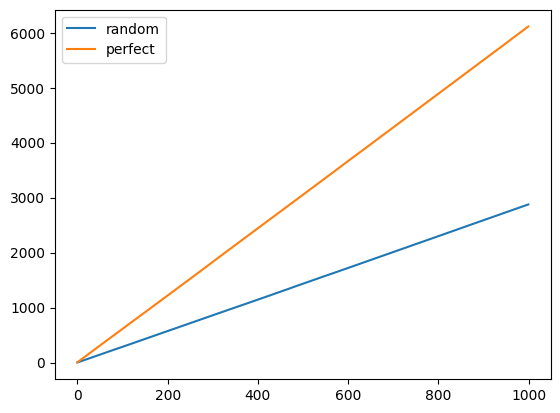

In [9]:
# wyniki sumaryczne dla wszystkich epok

runner.plot_results(results, runs, epochs, mode='cumulative')


Aggregated results:

perfect: 6.64
random: 3.12


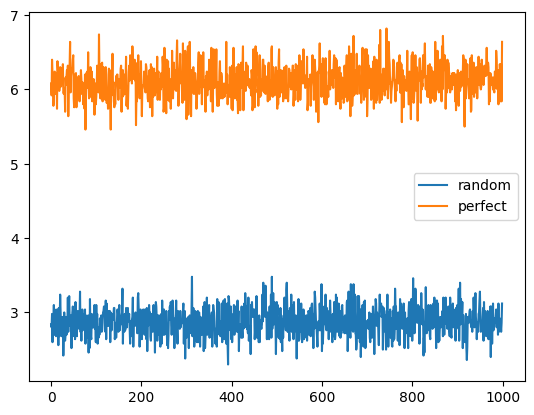

In [10]:
# wyniki per epoka

runner.plot_results(results, runs, epochs, mode='average')

## Część 2. - bandyci właściwi

In [11]:
class EGreedy(Bandit):
    def __init__(self, bandit_id, arm_ids, epsilon):
        super().__init__(bandit_id, arm_ids)
        self.epsilon = epsilon

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}  # ile razy zostalo zarekomendowane
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}  # ile razy zostalo zarekomendowane i wybrane
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}  # funkcja celu

    def recommend(self, size):
        # Sort arm_ids by the value of payouts_per_recommendation in descending order
        sorted_arm_ids = sorted(arm_ids, key=lambda x: self.payouts_per_recommendation[x], reverse=True)

        # Create a shuffled copy of the arm_ids list
        random_arm_ids = copy(arm_ids)
        shuffle(random_arm_ids)

        recommendation = []
        for i in range(size):
            random_val = uniform(0, 1)

            # Choose an arm to recommend from the shuffled list of arm_ids
            recommended_arm = random_arm_ids[i]

            # Check if the random value is greater than the epsilon value
            if random_val > self.epsilon:
                # If random value is greater than epsilon, choose the arm with the highest payouts_per_recommendation
                recommended_arm = sorted_arm_ids[i]

            # Append the recommended arm to the recommendation list if it is not there already and update the count of how many times this arm has been recommended
            if recommended_arm not in recommendation:
                recommendation.append(recommended_arm)
                self.recommended_rates[recommended_arm] += 1

        return recommendation

    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]

In [12]:
class UCB(Bandit):
    def __init__(self, bandit_id, arm_ids, optimism_weight):
        super().__init__(bandit_id, arm_ids)
        self.optimism_weight = optimism_weight

        # te zera w mianowniku moga byc problematyczne
        # - zastanow sie, czy lepiej je obslugiwac w locie czy zainicjalizowac te mape wartosciami niezerowymi
        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
        self.n = 0

    def recommend(self, size):
        # Add optimism to the values of the payout_per_recommendation for each arm
        payouts_with_optimism = copy(self.payouts_per_recommendation)
        for arm_id in arm_ids:
            payouts_with_optimism[arm_id] += (self.optimism_weight * self._optimism(arm_id))

        # Sort arms by the optimistic value of the payout function
        recommendation = sorted(arm_ids, key=lambda x: payouts_with_optimism[x], reverse=True)

        # Increase the number of recommendations for each arm based on 'size'
        for i in range(size):
            self.recommended_rates[recommendation[i]] += 1

        # Return the top 'size' arms with the highest optimistic values
        return recommendation[:size]

    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]

    def _optimism(self, arm):
        if self.recommended_rates[arm] == 0:
            return 1.0
        self.n = sum(self.recommended_rates.values())  # suma impresji wszystkich impresji elementów do zarekomendowania
        return self.optimism_weight * sqrt(log(self.n) / self.recommended_rates[arm])

In [13]:
class ThompsonSampling(Bandit):
    def __init__(self, bandit_id, arm_ids, reward_multiplier, regret_multiplier):
        super().__init__(bandit_id, arm_ids)
        self.reward_multiplier = reward_multiplier
        self.regret_multiplier = regret_multiplier
        self.a = {arm_id: 1 for arm_id in arm_ids}
        self.b = {arm_id: 1 for arm_id in arm_ids}

    def recommend(self, size):
        # For each arm, sample a value from the beta distribution with parameters a and b
        payouts = {arm_id: betavariate(self.a[arm_id], self.b[arm_id]) for arm_id in arm_ids}

        # Sort descending arms based on the sampled values from the beta distribution
        recommendation = sorted(arm_ids, key=lambda x: payouts[x], reverse=True)

        # Return the top 'size' arms with the highest sampled values
        return recommendation[:size]

    def feedback(self, arm_id, payout):
        reward = payout * self.reward_multiplier
        regret = max(1 - payout, 0) * self.regret_multiplier
        self.a[arm_id] += reward
        self.b[arm_id] += regret

## Część 3. - zgrubne porównanie bandytów

In [14]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]
# nie wahaj sie wybrac innych wartosci parametrow bandytow
bandits.extend([EGreedy('egreedy_%s' % epsilon, arm_ids, epsilon) for epsilon in [0.01, 0.05, 0.1, 0.25]])
bandits.extend([UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight) for optimism_weight in [0.01, 0.1, 1, 10]])
bandits.extend([ThompsonSampling('ts_%s_%s' % (reward_weight, regret_weight), arm_ids, reward_weight, regret_weight)
                for reward_weight, regret_weight in product([1, 5, 10, 20, 50], [1, 5, 10, 20, 50])])

In [15]:
runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect
Simulating: egreedy_0.01
Simulating: egreedy_0.05
Simulating: egreedy_0.1
Simulating: egreedy_0.25
Simulating: ucb_0.01
Simulating: ucb_0.1
Simulating: ucb_1
Simulating: ucb_10
Simulating: ts_1_1
Simulating: ts_1_5
Simulating: ts_1_10
Simulating: ts_1_20
Simulating: ts_1_50
Simulating: ts_5_1
Simulating: ts_5_5
Simulating: ts_5_10
Simulating: ts_5_20
Simulating: ts_5_50
Simulating: ts_10_1
Simulating: ts_10_5
Simulating: ts_10_10
Simulating: ts_10_20
Simulating: ts_10_50
Simulating: ts_20_1
Simulating: ts_20_5
Simulating: ts_20_10
Simulating: ts_20_20
Simulating: ts_20_50
Simulating: ts_50_1
Simulating: ts_50_5
Simulating: ts_50_10
Simulating: ts_50_20
Simulating: ts_50_50



Aggregated results:

ts_20_5: 6.56
ts_5_5: 6.48
ts_1_5: 6.32
ts_1_10: 6.28
ts_5_1: 6.22
ts_20_1: 6.2
ts_5_20: 6.1
ts_20_10: 6.1
perfect: 6.08
ts_5_10: 6.08
ts_1_20: 6.06
ucb_1: 6.02
ts_1_1: 6.0
ts_10_20: 5.96
egreedy_0.01: 5.94
ts_10_5: 5.88
ts_1_50: 5.82
ts_10_10: 5.82
egreedy_0.05: 5.8
ts_5_50: 5.72
ts_10_1: 5.7
egreedy_0.1: 5.66
ts_50_1: 5.62
ts_10_50: 5.54
ts_50_10: 5.4
ts_20_50: 5.36
egreedy_0.25: 5.24
ts_50_50: 5.18
ts_50_20: 5.1
ts_20_20: 5.08
ucb_0.1: 4.98
ucb_0.01: 4.94
ts_50_5: 4.68
random: 2.96
ucb_10: 2.62


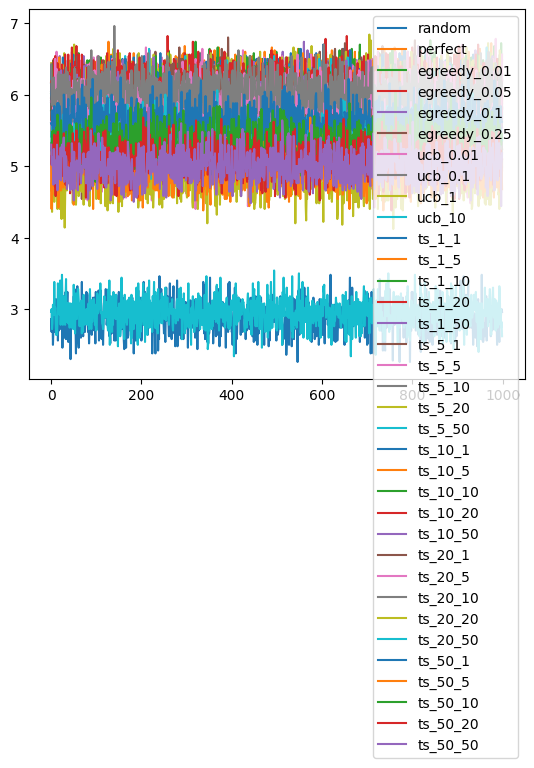

In [16]:
runner.plot_results(results, runs, epochs, mode='average')


Aggregated results:

ts_10_20: 6107.6799999999985
ts_5_20: 6102.019999999997
ts_5_1: 6101.600000000008
perfect: 6099.079999999999
ts_5_5: 6094.799999999992
ts_1_20: 6094.719999999992
ts_1_5: 6091.320000000005
ts_1_1: 6088.720000000001
ts_1_10: 6081.499999999988
egreedy_0.01: 6077.1799999999985
ts_1_50: 6056.440000000006
ts_20_10: 6054.320000000006
ucb_1: 6009.9199999999955
ts_10_1: 6005.040000000001
ts_5_50: 5965.919999999998
ts_10_10: 5964.7
ts_5_10: 5946.439999999998
egreedy_0.05: 5905.0199999999895
ts_20_5: 5898.32
ts_10_5: 5879.940000000007
ts_20_1: 5836.9599999999955
ts_10_50: 5821.020000000007
egreedy_0.1: 5744.4
ts_50_1: 5625.219999999992
ts_20_50: 5388.379999999996
ts_50_10: 5335.7800000000025
ucb_0.1: 5236.900000000003
egreedy_0.25: 5207.799999999996
ts_50_20: 5092.239999999998
ucb_0.01: 5049.839999999993
ts_50_50: 4994.759999999998
ts_50_5: 4963.479999999998
ts_20_20: 4819.419999999998
ucb_10: 2956.58
random: 2872.160000000002


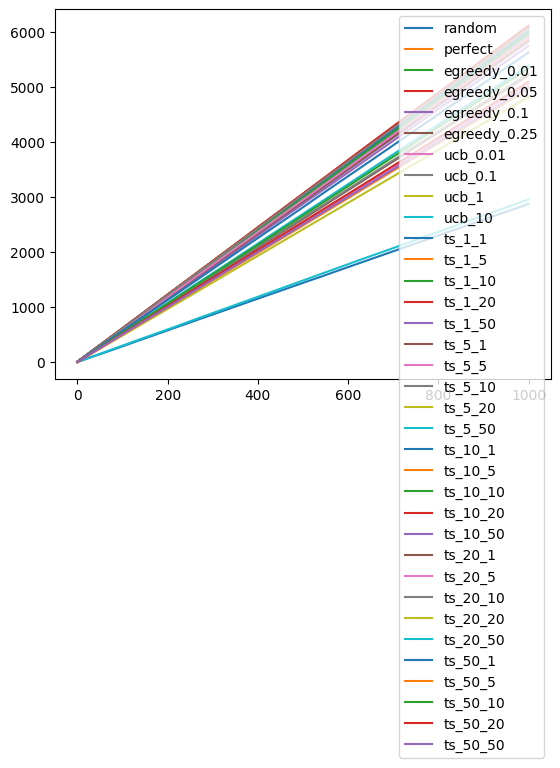

In [17]:
runner.plot_results(results, runs, epochs, mode='cumulative')

## Część 4. - dokładne porównanie bandytów

In [18]:
# obliczmy liste wszystkich dobrych ramion (arm_id zaczyna sie od 'good_') w rekomendacji
def relevant(recommendation: List[Arm]) -> int:
    return sum(1 for arm in recommendation if arm.arm_id.startswith('good_'))


all_relevant = relevant(arms.values())

In [19]:
# obliczmy precision@k i recall@k (zgodnie ze wzorami z wykladu)
def precision_at_k(recommendation: List[Arm], k: int) -> float:
    # Ensure k is not greater than the length of the recommendation list
    k = min(k, len(recommendation))

    # Use list comprehension to count true positives and false positives
    true_positives = relevant(recommendation[:k])

    # Calculate and return precision
    return true_positives / k if k > 0 else 0.0


def recall_at_k(recommendation: List[Arm], k: int, all_relevant: int) -> float:
    # Ensure k is not greater than the length of the recommendation list
    k = min(k, len(recommendation))

    # Calculate true positives using relevant function
    true_positives = relevant(recommendation[:k])

    # Calculate and return recall
    return true_positives / all_relevant if all_relevant > 0 else 0.0

In [20]:
# sprawdzmy, czy dziala
sample_bandit = bandits[-1]
k = 3
recommendation_ids = sample_bandit.recommend(recommendation_size)
recommendation = [arms[arm_id] for arm_id in recommendation_ids]
print(f'Precision@{k} for bandit {sample_bandit.bandit_id}: {precision_at_k(recommendation, k)}')
print(f'Recall@{k} for bandit {sample_bandit.bandit_id}: {recall_at_k(recommendation, k, all_relevant)}')

Precision@3 for bandit ts_50_50: 1.0
Recall@3 for bandit ts_50_50: 0.3


In [21]:
bandits[:15]

In [22]:
# wybieramy kilku istniejacych, wytrenowanych bandytow (perfect, random, po jednym e-greedy, UCB, TS)
testing_bandits = [
    bandits[0],  # random bandit
    bandits[1],  # perfect bandit
    bandits[4],  # egreedy bandit
    bandits[7],  # ucb bandit
    bandits[14]  # ts bandit
]
# wybieramy wartosci k do porownania
k_vals = [3, 5, 10]
# bedziemy liczyc sredni precision i recall dla `samples` rekomendacji
samples = 10

# dla kazdego bandyty - genetujemy `samples` rekomendacji, liczymy precision i recall, wypisujemy srednie wartosci
# powtarzamy dla kazdego k
precision_results = {k: {} for k in k_vals}
recall_results = {k: {} for k in k_vals}

for bandit in testing_bandits:
    for k in k_vals:
        precision_sum = recall_sum = 0

        for _ in range(samples):
            recommendation_ids = bandit.recommend(k)
            recommendation = [arms[arm_id] for arm_id in recommendation_ids]

            precision = precision_at_k(recommendation, k)
            recall = recall_at_k(recommendation, k, all_relevant)

            precision_sum += precision
            recall_sum += recall

        # Calculate the average precision and recall for this bandit and k
        precision_avg = precision_sum / samples
        recall_avg = recall_sum / samples

        # Store the results
        precision_results[k][bandit.bandit_id] = precision_avg
        recall_results[k][bandit.bandit_id] = recall_avg

# Print the results
for k in k_vals:
    print(f'Precision@{k}:')
    for bandit_id, precision in precision_results[k].items():
        print(f'{bandit_id}: {precision:.4f}')
    print()

    print(f'Recall@{k}:')
    for bandit_id, recall in recall_results[k].items():
        print(f'{bandit_id}: {recall:.4f}')
    print()

Precision@3:
random: 0.0333
perfect: 1.0000
egreedy_0.1: 0.9000
ucb_0.1: 1.0000
ts_1_50: 1.0000

Recall@3:
random: 0.0100
perfect: 0.3000
egreedy_0.1: 0.2700
ucb_0.1: 0.3000
ts_1_50: 0.3000

Precision@5:
random: 0.1200
perfect: 1.0000
egreedy_0.1: 0.8600
ucb_0.1: 1.0000
ts_1_50: 1.0000

Recall@5:
random: 0.0600
perfect: 0.5000
egreedy_0.1: 0.4300
ucb_0.1: 0.5000
ts_1_50: 0.5000

Precision@10:
random: 0.0800
perfect: 1.0000
egreedy_0.1: 0.9000
ucb_0.1: 0.7000
ts_1_50: 1.0000

Recall@10:
random: 0.0800
perfect: 1.0000
egreedy_0.1: 0.9000
ucb_0.1: 0.7000
ts_1_50: 1.0000

